# VGG

This notebook uses model "VGG16" to conduct regression of images.

In [1]:
import h5py
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision import models

## Step 1 - Config

First set the hyperparameters and other configurations.

In [2]:
# Dataset and model path
DATASET_PATH = "/home/ubuntu/Desktop/Ra/datasets/Ra_128_indexed_decimal_2.h5"
MODEL_PATH = "/home/ubuntu/Desktop/Ra/models/VGG_128_regression_decimal_2.pth"
OUTPUT_PATH = "/home/ubuntu/Desktop/Ra/outputs/VGG_128_regression_decimal_2.csv"
# Env
SEED = 42
# Dataset
MIN_LABEL = 1.3
MAX_LABEL = 5.2
# Hyperparameters
NUM_EPOCHS = 200
LR = 1e-3
LR_WEIGHT_DECAY = 1e-4
TEST_SIZE = 0.2
BATCH_SIZE_TRAIN = 64
BATCH_SIZE_VAL = 10

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

# Path
if not os.path.exists(os.path.dirname(MODEL_PATH)):
    os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)
    print(f"Make new directory {os.path.dirname(MODEL_PATH)}")

Device: cuda


Then load the pretrained model from `torchvision`.

In [3]:
# Pretrained VGG16 model
vgg16 = models.vgg16(pretrained=True)

# Change the last layer to fit the regression task
vgg16.classifier[-1] = nn.Linear(in_features=4096, out_features=1)

# Choose to freeze the layers or not
for param in vgg16.features.parameters():
    param.requires_grad = False

# Move to the appropriate device
vgg16 = vgg16.to(device)

/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Step 2 - Load data

In this step we load the images and process them, the goal is to get `train_loader` and `val_loader` for training. After this step we will get:

1. `images_train` and `images_val` (4 dim tensor)
2. `labels_train` and `labels_val` (1 dim tensor)
3. `train_dataset` and `val_dataset` (dataset)
4. `train_loader` and `val_loader` (dataloader)

First we load the images, and normalize the pixel values.

In [4]:
# Load datasets
with h5py.File(DATASET_PATH, "r") as f:
    images = f["images"][:].astype(float)
    labels = f["labels"][:].astype(float)
N_all = len(images)
print("Images and labels loaded.")
print(f"Images Shape: {images.shape}")
print(f"Labels Shape: {labels.shape}")
print("")

# Selection
indx = np.where((labels >= MIN_LABEL) * (labels < MAX_LABEL) == True)[0]
labels = labels[indx]
images = images[indx]
print(f"Select indexes by MIN_LABEL = {MIN_LABEL} and MAX_LABEL = {MAX_LABEL}")
print(f"Images Shape: {images.shape}")
print(f"Labels Shape: {labels.shape}")
print("")

# To tensor
images = torch.from_numpy(images).permute(0, 3, 1, 2)
labels = torch.from_numpy(labels)
print("Transform `images` and `labels` to tensors.")
print(f"Images Shape: {images.shape}")
print(f"Labels Shape: {labels.shape}")

# Image standardization
mean = images.mean(dim=[0, 2, 3], keepdim=True)
std = images.std(dim=[0, 2, 3], keepdim=True)
images = (images - mean) / std

# Label normalization
labels = (labels - MIN_LABEL) / (MAX_LABEL - MIN_LABEL)

Images and labels loaded.
Images Shape: (9192, 128, 128, 3)
Labels Shape: (9192,)

Select indexes by MIN_LABEL = 1.3 and MAX_LABEL = 5.2
Images Shape: (9192, 128, 128, 3)
Labels Shape: (9192,)

Transform `images` and `labels` to tensors.
Images Shape: torch.Size([9192, 3, 128, 128])
Labels Shape: torch.Size([9192])


Then use `train_test_split` function to get data for training and validation.

In [5]:
# Train-test split
images_train, images_val, labels_train, labels_val = train_test_split(
    images, labels, test_size=TEST_SIZE, random_state=SEED
)
print(f"Train test split with test size {TEST_SIZE}.")
print(f"Images (train) Shape: {images_train.shape}")
print(f"Images (val) Shape: {images_val.shape}")
print(f"Labels (train) Shape: {labels_train.shape}")
print(f"Labels (val) Shape: {labels_val.shape}")

Train test split with test size 0.2.
Images (train) Shape: torch.Size([7353, 3, 128, 128])
Images (val) Shape: torch.Size([1839, 3, 128, 128])
Labels (train) Shape: torch.Size([7353])
Labels (val) Shape: torch.Size([1839])


Next, we should transform the data to tensors, combine `images` and `labels` to datasets and get dataloaders according to `BATCH_SIZE`.

In [6]:
# Change to tensor
images_train_tensor = torch.tensor(images_train, dtype=torch.float32)
images_val_tensor = torch.tensor(images_val, dtype=torch.float32)
labels_train_tensor = torch.tensor(labels_train, dtype=torch.float32).view(-1, 1)
labels_val_tensor = torch.tensor(labels_val, dtype=torch.float32).view(-1, 1)
print(f"Shape of `images_train_tensor`: {images_train_tensor.shape}")
print(f"Shape of `labels_train_tensor`: {labels_train_tensor.shape}")
print(f"Shape of `images_val_tensor`: {images_val_tensor.shape}")
print(f"Shape of `labels_val_tensor`: {labels_val_tensor.shape}")

# Tensor's dataset
train_dataset = TensorDataset(images_train_tensor, labels_train_tensor)
val_dataset = TensorDataset(images_val_tensor, labels_val_tensor)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE_VAL)

/tmp/ipykernel_5461/1722485521.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images_train_tensor = torch.tensor(images_train, dtype=torch.float32)


Shape of `images_train_tensor`: torch.Size([7353, 3, 128, 128])
Shape of `labels_train_tensor`: torch.Size([7353, 1])
Shape of `images_val_tensor`: torch.Size([1839, 3, 128, 128])
Shape of `labels_val_tensor`: torch.Size([1839, 1])


/tmp/ipykernel_5461/1722485521.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images_val_tensor = torch.tensor(images_val, dtype=torch.float32)
/tmp/ipykernel_5461/1722485521.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_train_tensor = torch.tensor(labels_train, dtype=torch.float32).view(-1, 1)
/tmp/ipykernel_5461/1722485521.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_val_tensor = torch.tensor(labels_val, dtype=torch.float32).view(-1, 1)


## Step 3 - Train

Start training for `epoch` loops, record the training losses and validation losses.

In [7]:
# Criterion and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(
    vgg16.classifier.parameters(), lr=LR, weight_decay=LR_WEIGHT_DECAY
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=5
)

# Record the loss values
train_loss_list = []
val_loss_list = []

# # Loop by epoch
# for epoch in range(NUM_EPOCHS):

#     # Train
#     vgg16.train()
#     train_loss = 0.0
#     train_size = 0
#     for batch_images, batch_labels in train_loader:
#         # Load data
#         batch_images = batch_images.to(device)
#         batch_labels = batch_labels.to(device)
#         # Pass loss value
#         outputs = vgg16(batch_images)
#         loss = criterion(outputs, batch_labels)
#         # Back propagation
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         # Add to the total loss
#         batch_size = batch_images.size(0)
#         train_loss += loss.item() * batch_size
#         train_size += batch_size

#     train_loss = train_loss / train_size
#     train_loss_list.append(train_loss)

#     # Validate
#     vgg16.eval()
#     val_loss = 0
#     val_samples = 0
#     with torch.no_grad():
#         for batch_images, batch_labels in val_loader:
#             # Load data
#             batch_images = batch_images.to(device)
#             batch_labels = batch_labels.to(device)
#             # Output
#             outputs = vgg16(batch_images)
#             # Calculate loss
#             loss = criterion(outputs, batch_labels)
#             # Add to total loss
#             batch_size = batch_images.size(0)
#             val_loss += loss.item() * batch_size
#             val_samples += batch_size
#     val_loss /= val_samples
#     val_loss_list.append(val_loss)

#     # Print
#     print(
#         f"[Epoch {(epoch+1):d} / {(NUM_EPOCHS):d}] [Train Loss {train_loss:f} (MSE)] [Valid Loss {val_loss:f} (MSE)] [Learning Rate: {optimizer.param_groups[0]['lr']}]"
#     )

#     # Scheduler
#     scheduler.step(val_loss)

Then we plot the graphs of `train_loss_list` and `val_loss_lost`.

In [8]:
# x = list(range(NUM_EPOCHS))
# plt.plot(x, train_loss_list, label="Train Loss", marker=".")
# plt.plot(x, val_loss_list, label="Val Loss", marker=".")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.title("Training and Validation Loss")
# plt.legend()
# plt.show()

## Step 4 - Save / load the model

After training, we need to save the models.

In [9]:
# # Save the trained model to disk
# torch.save(vgg16.state_dict(), MODEL_PATH)
# print(f"Model saved to {MODEL_PATH}")

To read the saved data, we can run the following codes:

In [10]:
# Load the trained model weights
vgg16.load_state_dict(torch.load(MODEL_PATH, map_location=device))
vgg16.eval()
print("Model loaded from", MODEL_PATH)

Model loaded from /home/ubuntu/Desktop/Ra/models/VGG_128_regression_decimal_2.pth


## Step 5 - Extract features

We extract the images' features from the second-to-last layer of the trained VGG16 net.

In [11]:
# Get features
def get_fc2_features(model, batch_images):
    features = []
    def hook_fn(module, input, output):
        features.append(output)
    handle = model.classifier[3].register_forward_hook(hook_fn)
    vgg16.eval()
    with torch.no_grad():
        _ = model(batch_images)
    handle.remove()
    return features[0]

# Get features
features_val = get_fc2_features(vgg16, images_val_tensor.to(device)).cpu().detach().numpy()
print(f"Shape of features of the images for validation: {features_val.shape}")

Shape of features of the images for validation: (1839, 4096)


We use t-SNE algorithm to decrease the features' dimemsion to 2, and plot the 2-dimensional features with gradual colors.

[[-23.71672    26.415329 ]
 [  7.7160463 -14.395617 ]
 [-10.594586   25.631182 ]
 ...
 [ 30.447472    2.878375 ]
 [ 56.39171     5.687482 ]
 [-36.39657   -12.323175 ]]


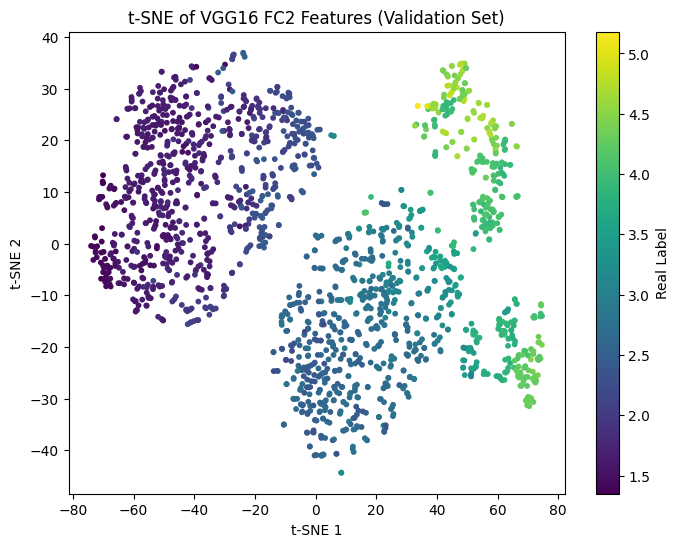

In [12]:
# Turn to `numpy.array`
labels_val_real = labels_val.numpy()
labels_val_predicted = vgg16(images_val_tensor.to(device)).cpu().detach().numpy()

# Unnormalize labels
labels_val_real = labels_val_real * (MAX_LABEL - MIN_LABEL) + MIN_LABEL
labels_val_predicted = labels_val_predicted * (MAX_LABEL - MIN_LABEL) + MIN_LABEL

# t-SNE
tsne = TSNE(n_components=2, random_state=SEED)
reduced_tsne = tsne.fit_transform(features_val)
print(reduced_tsne)

# Plot 2-dim features
plt.figure(figsize=(8, 6))
plt.scatter(reduced_tsne[:, 0], reduced_tsne[:, 1], c=labels_val_real, cmap='viridis', s=10)
plt.colorbar(label='Real Label')
plt.title('t-SNE of VGG16 FC2 Features (Validation Set)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

## Exceptional test

Let's see if the model works well.

      Real Labels  Predicted Labels      Diff      MAPE
0            1.75          1.617722 -0.132278  0.924413
1            2.70          2.687999 -0.012001  0.995555
2            1.82          1.913208  0.093208  0.948787
3            2.35          2.177352 -0.172648  0.926533
4            3.90          3.485659 -0.414341  0.893759
...           ...               ...       ...       ...
1834         2.05          1.843706 -0.206294  0.899369
1835         1.76          1.603919 -0.156081  0.911317
1836         2.59          2.798304  0.208304  0.919574
1837         4.09          3.790401 -0.299599  0.926748
1838         2.04          1.746847 -0.293153  0.856298

[1839 rows x 4 columns]
MAPE: 0.9249420151213672


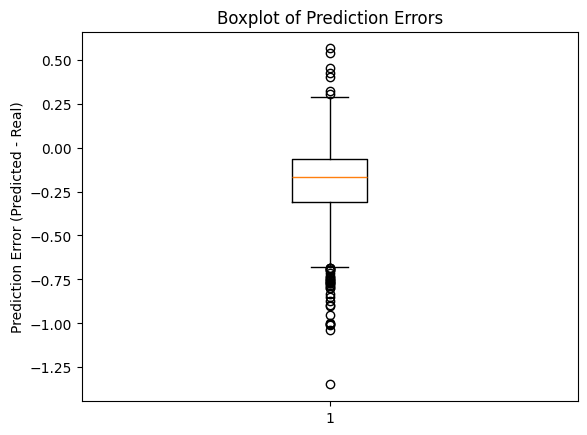

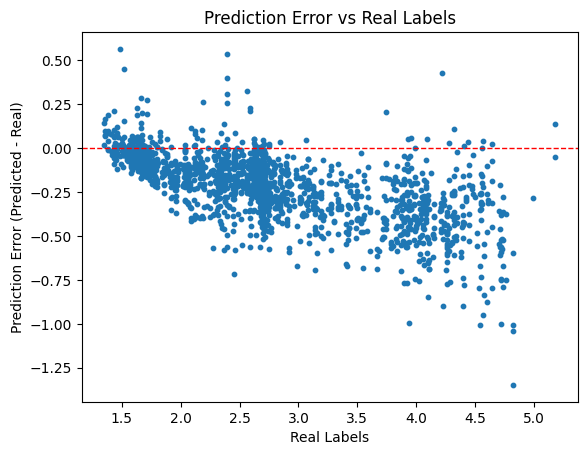

In [13]:
# Turn to `pandas.Series`
labels_val_real = pd.Series(labels_val_real)
labels_val_predicted = pd.Series(labels_val_predicted.flatten())
labels_val_diff = labels_val_predicted - labels_val_real

# Make `pandas.DataFrame`
df = pd.DataFrame(
    {
        "Real Labels": labels_val_real,
        "Predicted Labels": labels_val_predicted,
        "Diff": labels_val_diff,
        "MAPE": 1 - np.abs(labels_val_diff) / labels_val_real
    }
)
df.to_csv(OUTPUT_PATH, index = False)
print(df)
print(f"MAPE: {df["MAPE"].mean()}")

# Boxplot of the differences
plt.boxplot(labels_val_diff)
plt.ylabel("Prediction Error (Predicted - Real)")
plt.title("Boxplot of Prediction Errors")
plt.show()

# Plot the differences by the real labels.
plt.scatter(labels_val_real, labels_val_diff, s=10)
plt.xlabel("Real Labels")
plt.ylabel("Prediction Error (Predicted - Real)")
plt.title("Prediction Error vs Real Labels")
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.show()